*Eduardus Tjitrahardja | @edutjie | 2022*

# Assignment 1 - Heart Disease Classification

## Importing Libraries

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD

plt.style.use('seaborn')
pd.set_option('display.max_columns', None)

## Loading Dataset

In [131]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data', header=None)
df.columns = [
    "age",
    "sex",
    "cp",
    "trestbps",
    "chol",
    "fbs",
    "restecg",
    "thalach",
    "exang",
    "oldpeak",
    "slope",
    "ca",
    "thal",
    "target",
]
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [302]:
print("Dataset Shape: ", df.shape)
df.info()

Dataset Shape:  (303, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB


In [303]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000


In [304]:
df.isnull().any()

age         False
sex         False
cp          False
trestbps    False
chol        False
fbs         False
restecg     False
thalach     False
exang       False
oldpeak     False
slope       False
ca          False
thal        False
target      False
dtype: bool

## EDA

### Inspecting Target

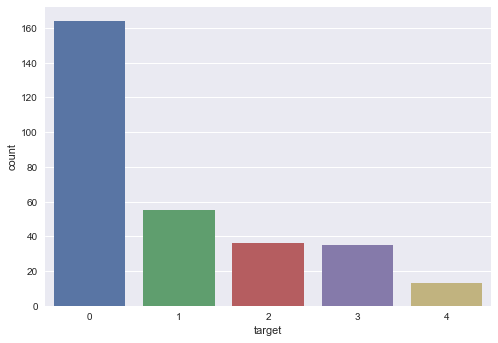

In [127]:
sns.countplot(x='target', data=df)
plt.show()

In [128]:
df.target.value_counts()

0    164
1     55
2     36
3     35
4     13
Name: target, dtype: int64

The target is **unbalanced**, most of them are in 0 class

#### Converting Target to Binary Classification (0=No Cancer, 1=Have Cancer)

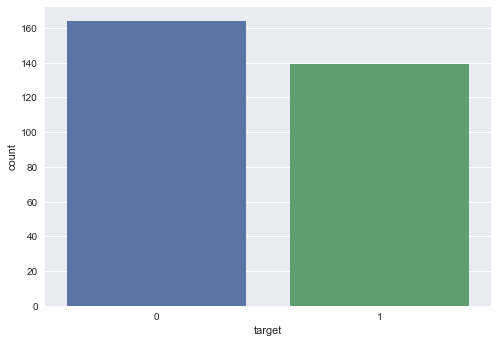

In [132]:
df['target'] = df.target.apply(lambda x: 1 if x > 0 else 0)
sns.countplot(x='target', data=df)
plt.show()

### Defining Features Columns

In [134]:
features_col = df.columns[:-1]
features_col

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

### Visualizing Features Distribution

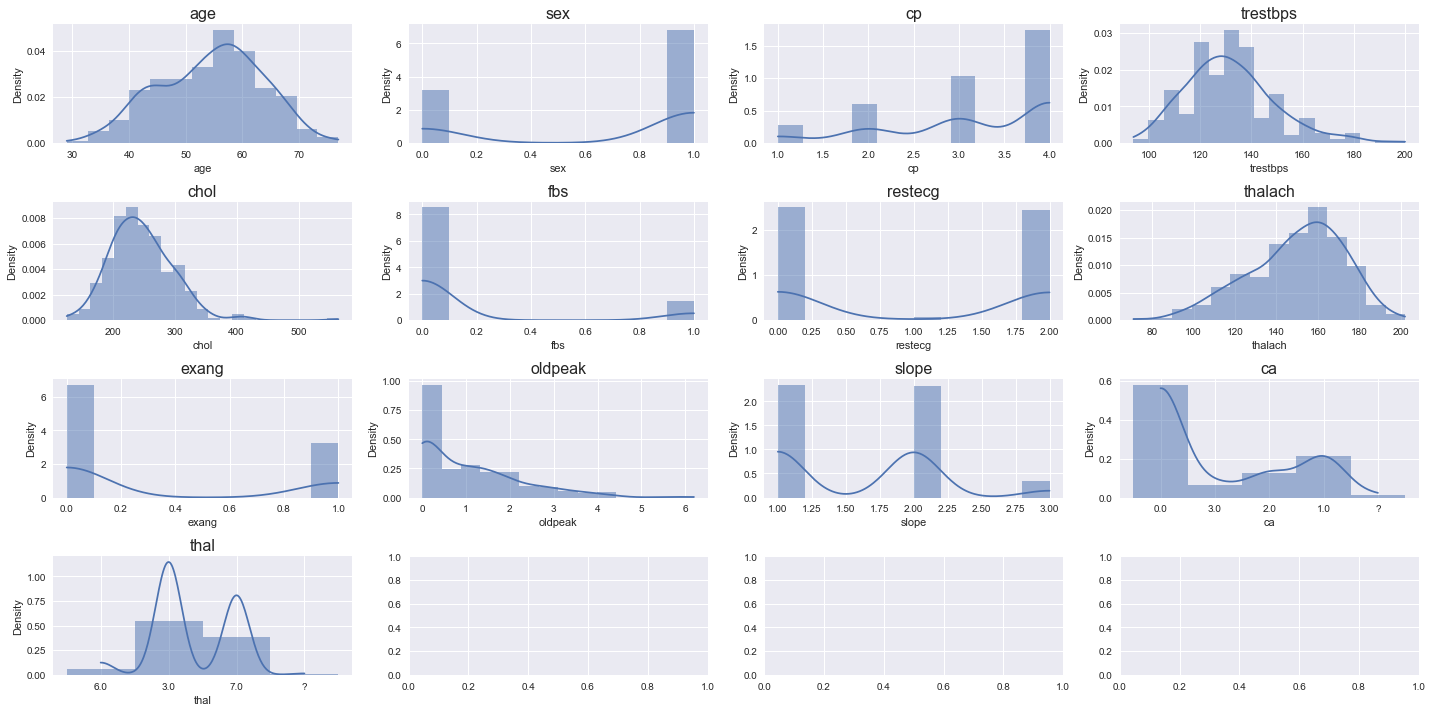

In [307]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 10))

for i, col in enumerate(features_col):
    sns.histplot(df[col], ax=axes[i // 4, i % 4], kde=True, stat="density", linewidth=0)
    axes[i // 4, i % 4].set_title(col, fontsize=16)
plt.tight_layout()

**Observations:**
- sex, fbs, exang features are binary categorical
- cp, slope, thal are nominal categorical
- restecg, ca are ordinal categorical
- trestbps, chol, oldpeak are right skewed
- thalach is left skewed

In [135]:
bin_cat_cols = ["sex", "fbs", "exang"]
nom_cat_cols = ["cp", "slope", "thal"]
ord_cat_cols = ["restecg", "ca"]
cat_cols = bin_cat_cols + nom_cat_cols + ord_cat_cols

num_cols = list(set(features_col) - set(cat_cols))

print("Binary Categorical Columns", bin_cat_cols)
print("Nominal Categorical Columns", nom_cat_cols)
print("Ordinal Categorical Columns", ord_cat_cols)
print("Numerical Columns", num_cols)

Binary Categorical Columns ['sex', 'fbs', 'exang']
Nominal Categorical Columns ['cp', 'slope', 'thal']
Ordinal Categorical Columns ['restecg', 'ca']
Numerical Columns ['chol', 'oldpeak', 'thalach', 'age', 'trestbps']


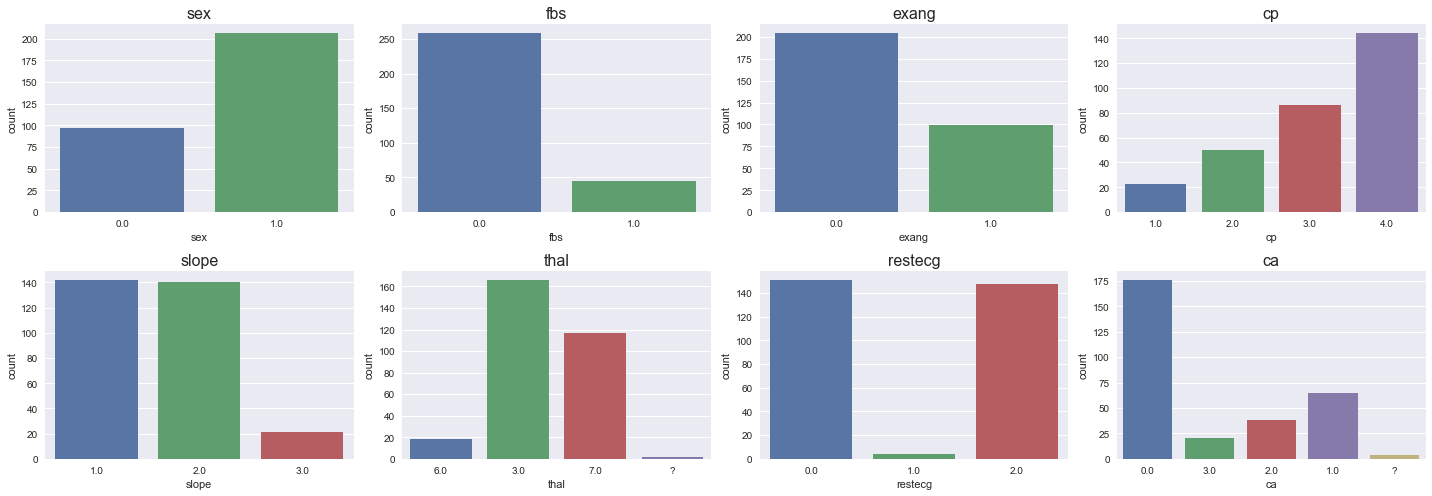

In [309]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 7))

for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=df, ax=axes[i // 4, i % 4])
    axes[i // 4, i % 4].set_title(col, fontsize=16)
plt.tight_layout()

### Droping ? value

In [136]:
df = df[df != "?"]
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df = df.astype({"ca": float, "thal": float})
print("Dataset Shape: ", df.shape)
print(f"ca type: {df.ca.dtype}, thal type: {df.thal.dtype}")
df.head()

Dataset Shape:  (297, 14)
ca type: float64, thal type: float64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


### Detecting Outlier using Z-score

In [137]:
dfz = df[num_cols].copy().add_prefix("z_")
dfz = dfz.apply(lambda x: (x - x.mean()) / x.std())
dfz.head()

,z_chol,z_oldpeak,z_thalach,z_age,z_trestbps
0,-0.275978,1.067164,0.017465,0.934603,0.749116
1,0.743301,0.381130,-1.813274,1.376605,1.593577
2,-0.352904,1.324427,-0.897904,1.376605,-0.658320
3,0.050961,2.096215,1.630258,-1.938409,-0.095345
4,-0.833696,0.295376,0.976423,-1.496407,-0.095345


In [138]:
outliers_index = []

for col in num_cols:
    outliers_index.extend(dfz[np.abs(dfz["z_" + col]) > 3].index.to_list())
    
outliers_index = list(set(outliers_index))
print(outliers_index)

[122, 186, 48, 242, 179, 151, 120, 90, 125]


### Dropping Outliers

In [139]:
df.drop(outliers_index, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(288, 14)

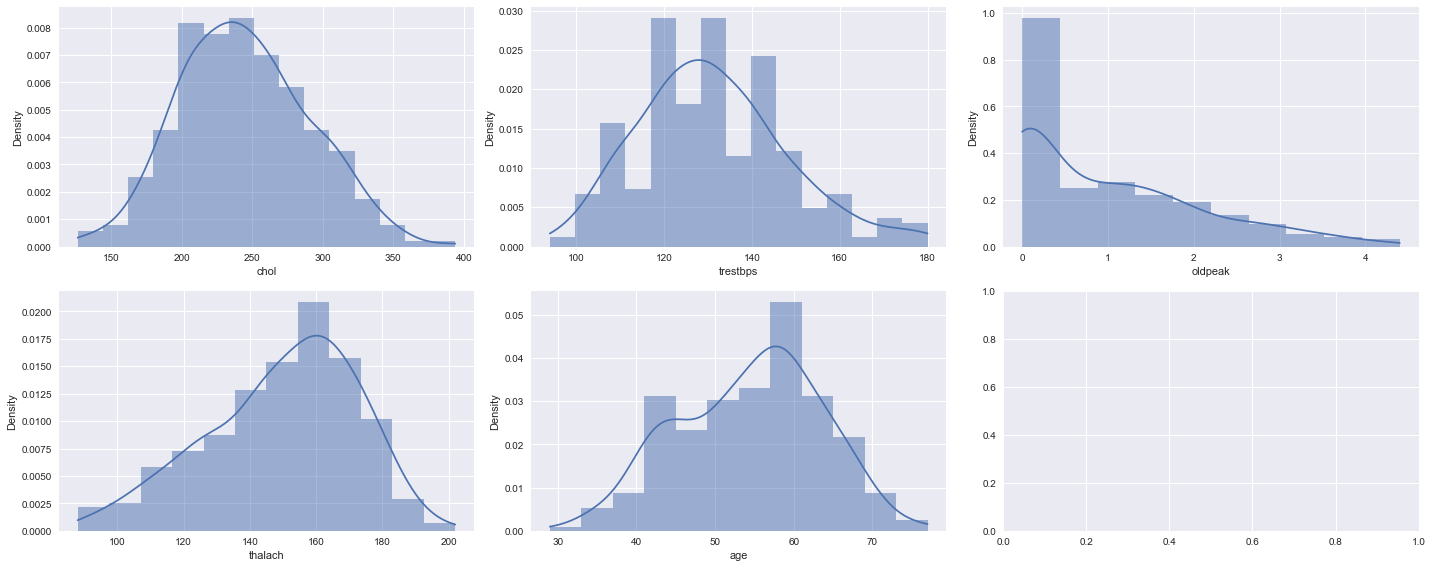

In [314]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))

for i, col in enumerate(num_cols):
    sns.histplot(df[col], ax=axes[i // 3, i % 3], kde=True, stat="density", linewidth=0)
plt.tight_layout()
plt.show()

### Visualizing Features Correlation

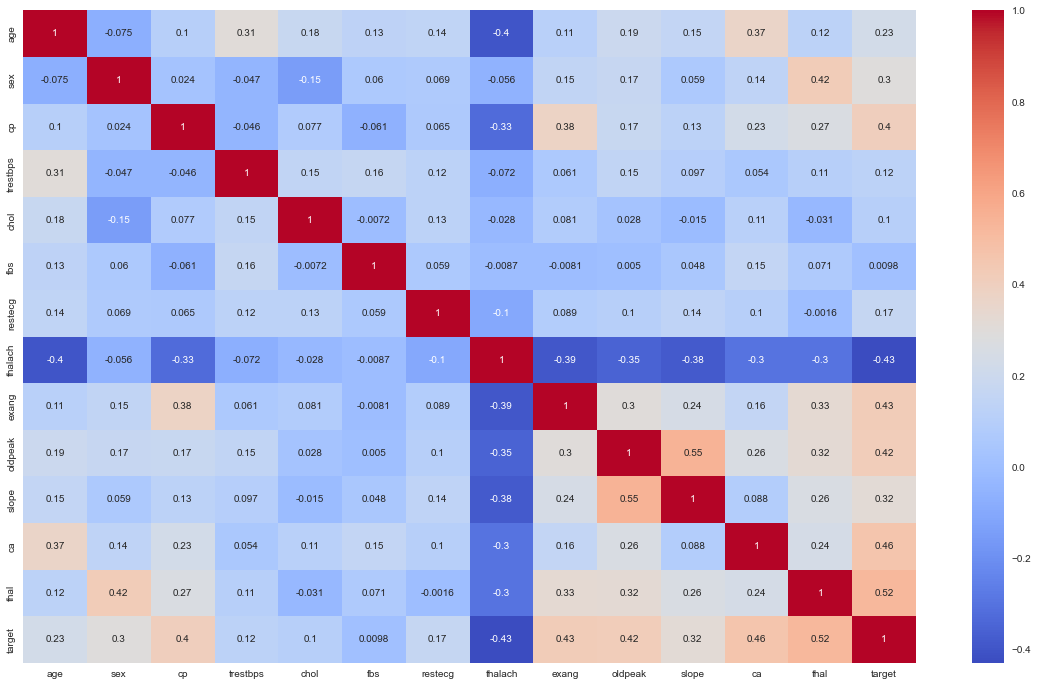

In [140]:
plt.subplots(figsize=(20, 12))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

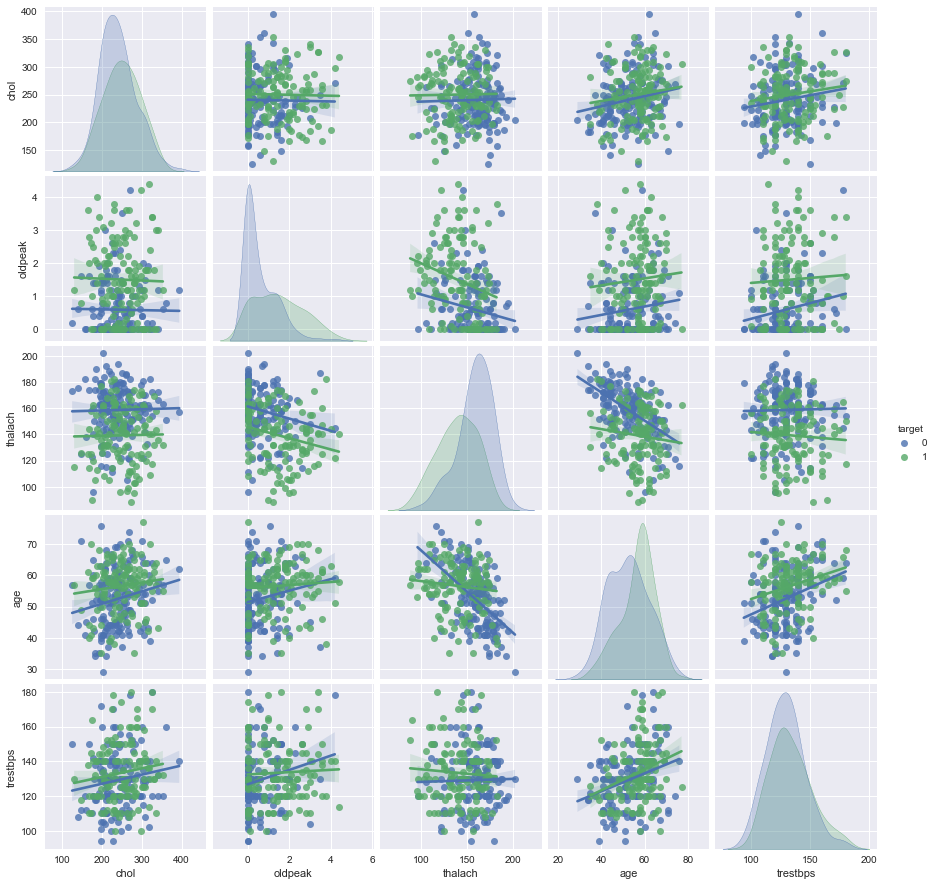

In [141]:
sns.pairplot(df[num_cols + ['target']], kind='reg', hue='target')
plt.show()

In [144]:
df.groupby('target').mean()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
target,,,,,,,,,,,,,
0,52.474684,0.563291,2.791139,129.196203,240.367089,0.139241,0.829114,158.582278,0.145570,0.591139,1.411392,0.272152,3.772152
1,56.638462,0.838462,3.576923,133.453846,249.992308,0.146154,1.161538,139.223077,0.546154,1.500000,1.800000,1.123077,5.800000


## Data Preprocessing

### One Hot Encoding Nominal Categorical Features

In [145]:
for col in nom_cat_cols:
    dummies = pd.get_dummies(df[col], prefix=col)
    df = pd.concat([df, dummies], axis=1)
    df.drop([col], axis=1, inplace=True)
df.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,target,cp_1.0,cp_2.0,cp_3.0,cp_4.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,0.0,0,1,0,0,0,0,0,1,0,1,0
1,67.0,1.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,3.0,1,0,0,0,1,0,1,0,1,0,0
2,67.0,1.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,1,0,0,0,1,0,1,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,0.0,0,0,0,1,0,0,0,1,1,0,0
4,41.0,0.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,0.0,0,0,1,0,0,1,0,0,1,0,0


### Label Encoding Ordinal and Binary Categorical Features

In [146]:
le = LabelEncoder()

for col in ord_cat_cols + bin_cat_cols:
    df[col] = le.fit_transform(df[col])
    
df.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,target,cp_1.0,cp_2.0,cp_3.0,cp_4.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
0,63.0,1,145.0,233.0,1,2,150.0,0,2.3,0,0,1,0,0,0,0,0,1,0,1,0
1,67.0,1,160.0,286.0,0,2,108.0,1,1.5,3,1,0,0,0,1,0,1,0,1,0,0
2,67.0,1,120.0,229.0,0,2,129.0,1,2.6,2,1,0,0,0,1,0,1,0,0,0,1
3,37.0,1,130.0,250.0,0,0,187.0,0,3.5,0,0,0,0,1,0,0,0,1,1,0,0
4,41.0,0,130.0,204.0,0,2,172.0,0,1.4,0,0,0,1,0,0,1,0,0,1,0,0


### Prepare Training Data

In [149]:
X = df.drop(["target"], axis=1)
y = df["target"]

print("X Shape:", X.shape)
print("y Shape:", y.shape)

X Shape: (288, 20)
y Shape: (288,)


In [150]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (201, 20)
y_train Shape: (201,)
X_test Shape: (87, 20)
y_test Shape: (87,)


### MinMax Scaling Numerical Features

In [151]:
mms = MinMaxScaler()

scaled_df = pd.DataFrame(mms.fit_transform(X_train[num_cols]), columns=num_cols, index=X_train.index)
scaled_df.head()

,chol,oldpeak,thalach,age,trestbps
232,0.461538,0.590909,0.491071,0.680851,0.465116
86,0.461538,0.000000,0.625000,0.510638,0.511628
223,0.320513,0.000000,0.651786,0.531915,0.767442
244,0.414530,0.068182,0.464286,0.808511,0.139535
112,0.329060,0.000000,0.375000,0.255319,0.476744


In [152]:
X_train.drop(num_cols, axis=1, inplace=True)
X_train = pd.concat([X_train, scaled_df], axis=1)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 232 to 102
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sex        201 non-null    int64  
 1   fbs        201 non-null    int64  
 2   restecg    201 non-null    int64  
 3   exang      201 non-null    int64  
 4   ca         201 non-null    int64  
 5   cp_1.0     201 non-null    uint8  
 6   cp_2.0     201 non-null    uint8  
 7   cp_3.0     201 non-null    uint8  
 8   cp_4.0     201 non-null    uint8  
 9   slope_1.0  201 non-null    uint8  
 10  slope_2.0  201 non-null    uint8  
 11  slope_3.0  201 non-null    uint8  
 12  thal_3.0   201 non-null    uint8  
 13  thal_6.0   201 non-null    uint8  
 14  thal_7.0   201 non-null    uint8  
 15  chol       201 non-null    float64
 16  oldpeak    201 non-null    float64
 17  thalach    201 non-null    float64
 18  age        201 non-null    float64
 19  trestbps   201 non-null    float64
dtypes: float

In [153]:
X_train.head()

,sex,fbs,restecg,exang,ca,cp_1.0,cp_2.0,cp_3.0,cp_4.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0,chol,oldpeak,thalach,age,trestbps
232,1,0,0,0,2,1,0,0,0,0,1,0,1,0,0,0.461538,0.590909,0.491071,0.680851,0.465116
86,0,0,2,0,0,0,0,0,1,1,0,0,1,0,0,0.461538,0.000000,0.625000,0.510638,0.511628
223,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0.320513,0.000000,0.651786,0.531915,0.767442
244,0,0,0,0,2,0,0,0,1,1,0,0,1,0,0,0.414530,0.068182,0.464286,0.808511,0.139535
112,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0.329060,0.000000,0.375000,0.255319,0.476744


In [154]:
scaled_df = pd.DataFrame(mms.fit_transform(X_test[num_cols]), columns=num_cols, index=X_test.index)
scaled_df.head()
X_test.drop(num_cols, axis=1, inplace=True)
X_test = pd.concat([X_test, scaled_df], axis=1)
X_test.head()

,sex,fbs,restecg,exang,ca,cp_1.0,cp_2.0,cp_3.0,cp_4.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0,chol,oldpeak,thalach,age,trestbps
45,1,0,2,0,1,0,0,1,0,0,1,0,0,0,1,0.376426,0.595238,0.754902,0.547619,0.150
157,1,1,0,0,2,0,0,1,0,1,0,0,1,0,0,0.471483,0.000000,0.852941,0.309524,0.300
256,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0.186312,0.000000,0.607843,0.166667,0.375
42,0,0,0,0,2,0,1,0,0,1,0,0,1,0,0,0.650190,0.095238,0.725490,0.857143,0.750
181,1,0,0,1,3,0,0,0,1,0,1,0,0,0,1,0.634981,1.000000,0.333333,0.380952,0.500


## Defining Model

In [195]:
trial = {
    "gradient_descent": {
        "label": "Gradient Descent (batch size = len(X_train), lr = 0.01)",
        "lr": 0.01,
        "batch_size": len(X_train),
    },
    "stochastic_gradient_descent": {
        "label": "Stochastic Gradient Descent (batch_size = 1, lr = 0.01)",
        "lr": 0.01,
        "batch_size": 1,
    },
    "stochastic_gradient_descent_lr_001": {
        "label": "Stochastic Gradient Descent (batch_size = 1, lr = 0.001)",
        "lr": 0.001,
        "batch_size": 1,
    },
    "mini_batch_gradient_descent": {
        "label": "Mini-Batch Gradient Descent (batch_size = 32, lr = 0.01)",
        "lr": 0.01,
        "batch_size": 32,
    },
}


In [156]:
def eval_model(model, X_train, y_train, X_test, y_test):
    _, train_acc = model.evaluate(X_train, y_train, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Train: {train_acc:.3f}, Test: {test_acc:.3f}")

In [157]:
def plot_history(history):
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Valid')
    plt.legend()
    plt.show()

In [196]:
def trial_model(
    lr,
    batch_size,
    epochs,
    X_train,
    y_train,
    X_test,
    y_test,
):
    model = Sequential()

    # input layer, that's why input_dim has to be the same as the number of columns in X
    # 1st hidden layer
    # hidden layer usually uses relu activation function because it's proven to be the best function
    model.add(Dense(16, input_dim=20, activation="relu"))

    # 2nd hidden layer
    model.add(Dense(16, activation="relu"))

    # output layer
    # using softmax as activation function, because the target is multi classification
    model.add(Dense(1, activation="sigmoid"))

    model.compile(
        loss="binary_crossentropy",
        optimizer=SGD(learning_rate=lr),
        metrics=["accuracy"],
    )
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        batch_size=batch_size,
        epochs=epochs,
        verbose=0,
    )
    eval_model(model, X_train, y_train, X_test, y_test)
    plot_history(history)
    return model


Gradient Descent (batch size = len(X_train), lr = 0.01)
Train: 0.836, Test: 0.782


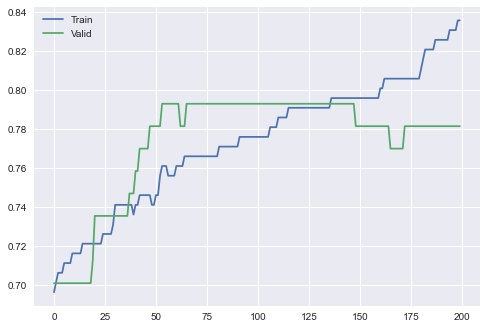

----------------------------------------

Stochastic Gradient Descent (batch_size = 1, lr = 0.01)
Train: 1.000, Test: 0.805


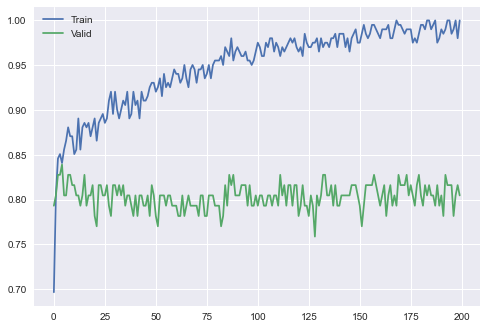

----------------------------------------

Stochastic Gradient Descent (batch_size = 1, lr = 0.001)
Train: 0.905, Test: 0.805


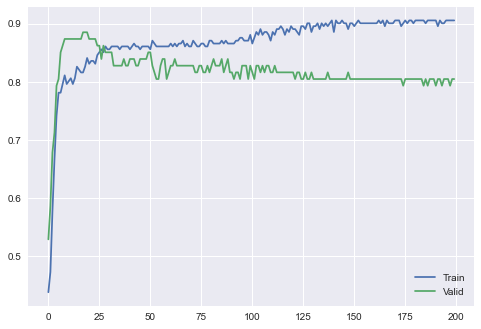

----------------------------------------

Mini-Batch Gradient Descent (batch_size = 32, lr = 0.01)
Train: 0.856, Test: 0.839


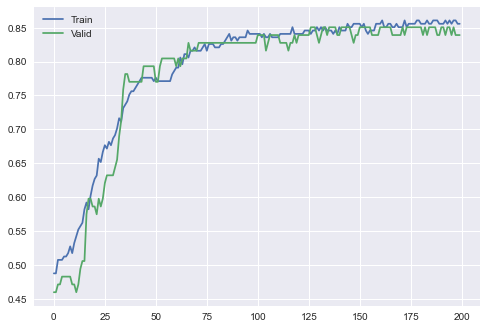

----------------------------------------



In [197]:
for key, params in trial.items():
    print(f"{params['label']}")
    trial_model(
        params["lr"], params["batch_size"], 200, X_train, y_train, X_test, y_test
    )
    print(40 * "-", end="\n\n")


**Observations:**
<!-- - Seems like the best model is Mini-Batch Gradient Descent (batch_size = 32, lr = 0.01), because its score is one of the highest and the graph of train and test data is almost fit. -->
- I'll choose Mini-Batch Gradient Descent because it the train and test graph **fits**.

### Testing Different Batch Sizes

In [198]:
def fit_model(
    lr,
    batch_size,
    epochs,
    X_train,
    y_train,
    X_test,
    y_test,
):
    # define model
    model = Sequential()
    model.add(Dense(16, input_dim=20, activation="relu"))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))

    # compile model
    model.compile(
        loss="binary_crossentropy",
        optimizer=SGD(learning_rate=lr),
        metrics=["accuracy"],
    )

    # fit model
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        verbose=0,
        batch_size=batch_size,
    )

    # plot learning curves
    plt.plot(history.history["accuracy"], label="train")
    plt.plot(history.history["val_accuracy"], label="test")
    plt.title(f"lr={lr}, batch={batch_size}, epochs={epochs}")
    plt.legend()


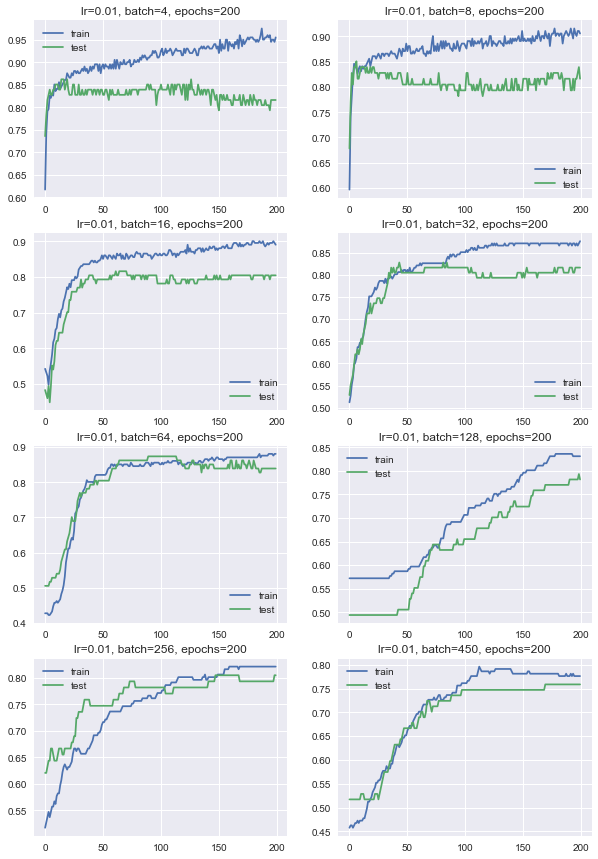

In [199]:
batch_sizes = [4, 8, 16, 32, 64, 128, 256, 450]

plt.figure(figsize=(10, 15))
for i in range(len(batch_sizes)):
    
    # determine the plot number
    plot_no = 420 + (i+1)
    plt.subplot(plot_no)
    
    # fit model and plot learning curves for a batch size
    fit_model(0.01, batch_sizes[i], 200, X_train, y_train, X_test, y_test)

# show learning curves
plt.show()

**Observations:**
- It seems that batch=64 is the best batch size. Because the train and test graph **fits** each other.

### Testing Different Learning Rates

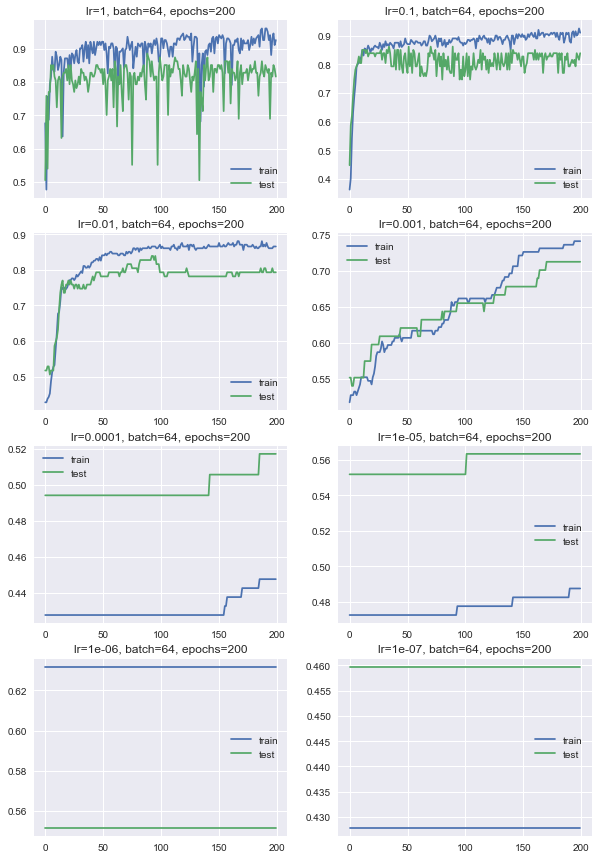

In [200]:
lrs = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]

plt.figure(figsize=(10, 15))
for i in range(len(lrs)):
    
    # determine the plot number
    plot_no = 420 + (i+1)
    plt.subplot(plot_no)
    
    # fit model and plot learning curves for a batch size
    fit_model(lrs[i], 64, 200, X_train, y_train, X_test, y_test)

# show learning curves
plt.show()

**Observations:**
- The best learning rate is in **0.01 - 0.1** range.
- I'll pick **0.01** learning rate.

### Testing Different Epochs

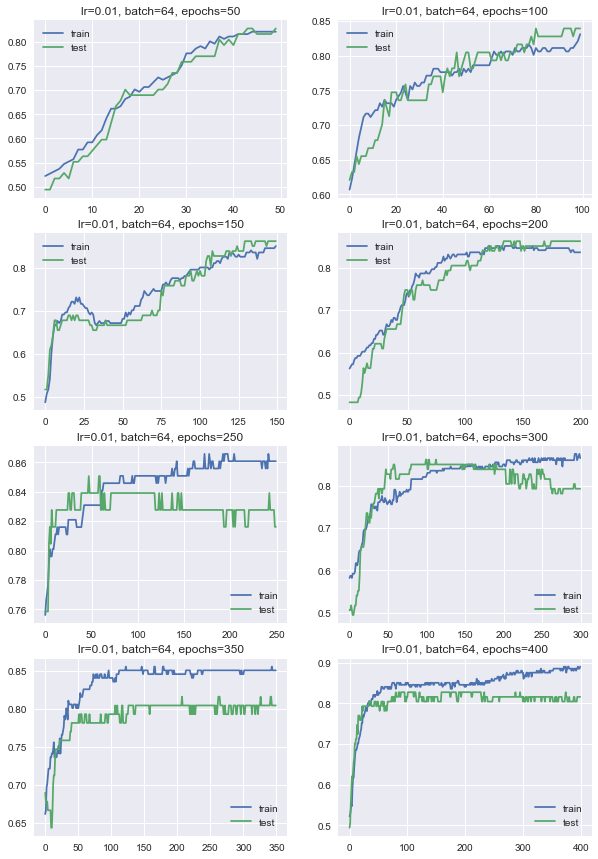

In [201]:
epochs = [50, 100, 150, 200, 250, 300, 350, 400]

plt.figure(figsize=(10, 15))
for i in range(len(epochs)):
    
    # determine the plot number
    plot_no = 420 + (i+1)
    plt.subplot(plot_no)
    
    # fit model and plot learning curves for a batch size
    fit_model(0.01, 64, epochs[i], X_train, y_train, X_test, y_test)

# show learning curves
plt.show()

**Observations:**
- The best epochs is in **100-200** range.
- I'll pick **200** epochs.

## Defining Final Model

Train: 0.856, Test: 0.828


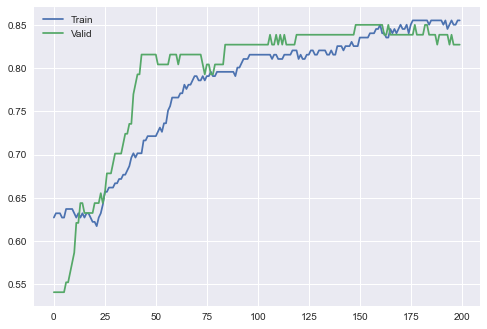

Model: "sequential_183"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_578 (Dense)           (None, 16)                336       
                                                                 
 dense_579 (Dense)           (None, 16)                272       
                                                                 
 dense_580 (Dense)           (None, 1)                 17        
                                                                 
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________


In [210]:
model = trial_model(0.01, 64, 200, X_train, y_train, X_test, y_test)
model.summary()

In [211]:
eval_model(model, X_train, y_train, X_test, y_test)

Train: 0.856, Test: 0.828


In [212]:
# predict on test data
predictions = model.predict(X_test)
predictions = (predictions.reshape(predictions.shape[0]) > 0.5).astype(int)
predictions

3/3 [==============================] - 0s 2ms/step


array([1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0])

In [213]:
y_test.values

array([1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
      dtype=int64)